In [1]:
# install the follwoing packages in the enviroment:
# python3 -m pip install pandas
# python3 -m pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import json

import os

from read_jsondata import read_jsons

import time

## Hypotheses to be tested

#### As reference values to compare to, we will use demographics from ECS from AGU and EGU. This will give an idea of how many of the active scientists at these professional levels are represented to the peer-reviewed articles (which is the main crucial factor for career advancing and perhaps the daily goal of most academics)

FIRST GLANCES AT DATA

- % of female first authors (hists?)
- % publications with all male vs. % publications with all female authors (hists?)

CO-AUTHORSHIP ANALYSES

- When 1st author is female: % of male vs. female co-authors (bars..?)
- When 1st author is female: likelihood of last author (possibly PI) to be female vs. male 
- When 1st author is male: % of female coauthors and % of male coauthors
- When the last name is female (possible PI), is there a higher % of female co-authors vs. male ones?

JOURNAL IF ANALYSES:

- Correlation between IF and female first authors: does higher IF mean fewer female first authors?




In [2]:
# Define local paths

root = ! pwd
root = root[0]

RAW_DIR=root+"/author_allgenders/"  

if not os.path.exists(RAW_DIR):
    print("The directory {} does not exist.\nThere is no raw data for statistical analysis.".format(RAW_DIR))

In [3]:
df = read_jsons(RAW_DIR)
df

,year,journal,all_genders,all_percent
0,2010,GRL,"[male, male]","[0.99, 0.99]"
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]"
2,2019,GEOPHYSICS,[male],[0.98]
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,..."
4,2014,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]"
...,...,...,...,...
19355,2012,E%26PSL,"[male, male]","[0.97, 0.99]"
19356,2020,GRL,"[male, male]","[0.88, 0.99]"
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]"
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]"


In [4]:
# clean some journal names

df.loc[df.journal=='E%26PSL','journal'] = 'EPSL'

df.loc[df.journal.str.contains("Bulletin"),'journal'] = 'BSSA'

df.loc[df.journal.str.contains("Seismological"),'journal'] = 'SRL'

# Include impact factor:

dict_IF = {'Nature': 46.486, 'Science': 41.845, 'NatureGeoscience': 16.103, 'EPSL': 4.823, 'GRL': 4.952, 
        'JGRSolidEarth': 4.191, 'G3': 3.721, 'SRL': 3.131, 'Tectp': 3.048, 'SolidEarth': 2.921, 
       'GEOPHYSICS': 3.093, 'GJI': 2.834, 'BSSA': 2.274, 'PEPI': 2.413}

df['IF'] = df['journal'].map(dict_IF)
df

,year,journal,all_genders,all_percent,IF
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048
2,2019,GEOPHYSICS,[male],[0.98],3.093
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845
4,2014,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",4.191
...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191


In [5]:
## Remove rows for papers from 2021

df = df[~df['year'].isin(['2021'])].copy()
df

,year,journal,all_genders,all_percent,IF
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048
2,2019,GEOPHYSICS,[male],[0.98],3.093
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845
4,2014,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",4.191
...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191


### Create new columns in the dataframe extracting useful information from list of coauthors

In [6]:
# Number of authors:

df['Number_authors'] = df['all_genders'].apply(lambda x: len(x)) #take the length of the list all_genders
df['Number_init'] = df['all_genders'].apply(lambda x: len([s for s in x if "init"==s]))


# First author's gender and percentage:

df['First_Author_gend'] = df['all_genders'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_perc'] = df['all_percent'].apply(lambda x: x[0])

# Last author's gender and percentage:

df['Last_Author_gend'] = df['all_genders'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_perc'] = df['all_percent'].apply(lambda x: x[-1])

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952,2,0,male,0.99,male,0.99
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,0,male,0.99,male,0.90
2,2019,GEOPHYSICS,[male],[0.98],3.093,1,0,male,0.98,male,0.98
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,0,male,0.99,male,0.99
4,2014,JGRSolidEarth,"[female, init, male, male]","[0.98, None, 1.0, 0.99]",4.191,4,1,female,0.98,male,0.99
...,...,...,...,...,...,...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,0,male,0.97,male,0.99
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952,2,0,male,0.88,male,0.99
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103,4,0,female,0.98,male,0.98
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191,2,0,female,0.50,male,0.99


In [7]:
df = df[df.Number_init==0].copy()
df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952,2,0,male,0.99,male,0.99
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,0,male,0.99,male,0.90
2,2019,GEOPHYSICS,[male],[0.98],3.093,1,0,male,0.98,male,0.98
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,0,male,0.99,male,0.99
5,2019,Tectp,"[male, male, male, male, male, male, male, fem...","[0.57, 0.74, 1.0, 1.0, 0.63, 0.93, 0.690361645...",3.048,8,0,male,0.57,female,1.00
...,...,...,...,...,...,...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,0,male,0.97,male,0.99
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952,2,0,male,0.88,male,0.99
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103,4,0,female,0.98,male,0.98
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191,2,0,female,0.50,male,0.99


 #### It is easier if the all probabilities are with respect to the same gender (female)

In [8]:
# prob(female) = 1 - prob(male)

# Prob last author female:

df['Last_Author_probF'] = df['Last_Author_perc']
df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF'] = \
    1 - df.loc[df['Last_Author_gend'] == 'male','Last_Author_probF']

# Prob first author female:

df['First_Author_probF'] = df['First_Author_perc']
df.loc[df['First_Author_gend'] == 'male','First_Author_probF'] = \
    1 - df.loc[df['First_Author_gend'] == 'male','First_Author_probF']

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952,2,0,male,0.99,male,0.99,0.01,0.01
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,0,male,0.99,male,0.90,0.10,0.01
2,2019,GEOPHYSICS,[male],[0.98],3.093,1,0,male,0.98,male,0.98,0.02,0.02
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,0,male,0.99,male,0.99,0.01,0.01
5,2019,Tectp,"[male, male, male, male, male, male, male, fem...","[0.57, 0.74, 1.0, 1.0, 0.63, 0.93, 0.690361645...",3.048,8,0,male,0.57,female,1.00,1.00,0.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,0,male,0.97,male,0.99,0.01,0.03
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952,2,0,male,0.88,male,0.99,0.01,0.12
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103,4,0,female,0.98,male,0.98,0.02,0.98
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191,2,0,female,0.50,male,0.99,0.01,0.50


## Now we can compute some interesting probabilities:

### Useful formulas:

Suppose $x_i$ refers to the article $i$ and $N$ is the total number of articles. Then, the probability of an article having female author is:

$$p(\text{female}) = \sum_{i}^N p(\text{female}|x_i) p(x_i). $$

If we have all the probabilities with respect to the female gender, then the probability of having a male author will be:

$$p(\text{male}) = \sum_{i}^N (1 - p(\text{female}|x_i)) p(x_i). $$

$p(x_i)$ is the probability of the article $x_i$. All articles have the same probability, therefore $p(x_i) = \frac{1}{N}$. This means that the formulas above are same as taking the average of  $p(\text{female}|x_i)$ or $(1 - p(\text{female}|x_i))$, respectively.


### Let's compute some easy statistics to start

In [9]:
print('Probability of having a female first author:', df['First_Author_probF'].sum()/df.shape[0])
print('Probability of having a male first author:', (1 - df['First_Author_probF']).sum()/df.shape[0])


print('Probability of having a female last author:', df['Last_Author_probF'].sum()/df.shape[0])
print('Probability of having a male last author:', (1 - df['Last_Author_probF']).sum()/df.shape[0])



Probability of having a female first author: 0.2766848593908223
Probability of having a male first author: 0.7233151406091777
Probability of having a female last author: 0.19080745892456286
Probability of having a male last author: 0.8091925410754371


#### Probabilities of having at least one male/female author in an article

Having at least one female author refers to any coauthor combination excluding the case in which all authors are male:

$$p(\text{at least 1 female}|x_i) = 1 - p(\text{all male}|x_i)$$

Computing probability for all male coauthors is easier. In the following, we drop the dependency on $x_i$ for clarity.

$$p(\text{all male}) = p(\text{male}_1)p(\text{male}_2|\text{male}_1)p(\text{male}_3|\text{male}_1,\text{male}_2)... = \prod_i^n p(\text{male}_i)$$

where n is the number of authors and the last step assumes that the gender probability of each authorship is independent of the gender of other coauthors (just to simplify the problem). 

In [10]:
#Define functions to multiply probabilities in each row

#prob at least a female author

def Prob_atleast_Fauthor(x,y):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= float(y[i]) 
        elif elem == 'female':
            prod *= 1 - float(y[i])
    return 1 - prod

#prob at least a male author

def Prob_atleast_Mauthor(x,y):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 1 - float(y[i]) 
        elif elem == 'female':
            prod *= float(y[i])
    return 1 - prod


# Create corresponding columns:

df['Prob_atleast_Fauthor'] = df.apply(lambda x: Prob_atleast_Fauthor(x.all_genders, x.all_percent), axis=1)
df['Prob_atleast_Mauthor'] = df.apply(lambda x: Prob_atleast_Mauthor(x.all_genders, x.all_percent), axis=1)

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,Last_Author_perc,Last_Author_probF,First_Author_probF,Prob_atleast_Fauthor,Prob_atleast_Mauthor
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952,2,0,male,0.99,male,0.99,0.01,0.01,0.019900,0.9999
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,0,male,0.99,male,0.90,0.10,0.01,0.563410,1.0000
2,2019,GEOPHYSICS,[male],[0.98],3.093,1,0,male,0.98,male,0.98,0.02,0.02,0.020000,0.9800
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,0,male,0.99,male,0.99,0.01,0.01,1.000000,1.0000
5,2019,Tectp,"[male, male, male, male, male, male, male, fem...","[0.57, 0.74, 1.0, 1.0, 0.63, 0.93, 0.690361645...",3.048,8,0,male,0.57,female,1.00,1.00,0.43,1.000000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,0,male,0.97,male,0.99,0.01,0.03,0.039700,0.9997
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952,2,0,male,0.88,male,0.99,0.01,0.12,0.128800,0.9988
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103,4,0,female,0.98,male,0.98,0.02,0.98,0.980792,1.0000
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191,2,0,female,0.50,male,0.99,0.01,0.50,0.505000,0.9950


In [11]:
print('Probability of having at least one female author in an article', 
      df['Prob_atleast_Fauthor'].sum()/df.shape[0])

print('Probability of having at least one male author in an article', 
      df['Prob_atleast_Mauthor'].sum()/df.shape[0])

print('or the opposite...')

print('Probability of having all female authors in an article', 
      1 - df['Prob_atleast_Mauthor'].sum()/df.shape[0])

print('Probability of having all male authors in an article', 
      1 - df['Prob_atleast_Fauthor'].sum()/df.shape[0])

Probability of having at least one female author in an article 0.5834848305216469
Probability of having at least one male author in an article 0.9735502121062583
or the opposite...
Probability of having all female authors in an article 0.02644978789374175
Probability of having all male authors in an article 0.4165151694783531


#### in between: Overall frequency of female / male authors

All probabilities sum:  0.9999862429495117
Overall frequency of female authorship:  23.469639101405466
Overall frequency of male authorship:  76.5289851935457
Overall frequency of unidentified names:  0.0
All probabilities sum:  0.9999862429495117
Overall frequency of female authorship after accounting for init:  23.469639101405466
Overall frequency of male authorship after accounting for init:  76.5289851935457
Probability that a paper with x author(s) has at least 1 female author:
x=1: p= 0.235 ;   x=2: p= 0.414 ;   x=3: p= 0.552 ;   p=10: p= 0.931
Probability that a paper with x author(s) has only female authors:
x=1: p= 0.235 ;   x=2: p= 0.055 ;   x=3: p= 0.013 ;   p=10: p= 0.0
[1071, 3656, 3564, 3170, 2426, 1239, 784, 503, 297, 208, 124, 83, 64, 48, 33, 26, 15, 9, 13, 7]


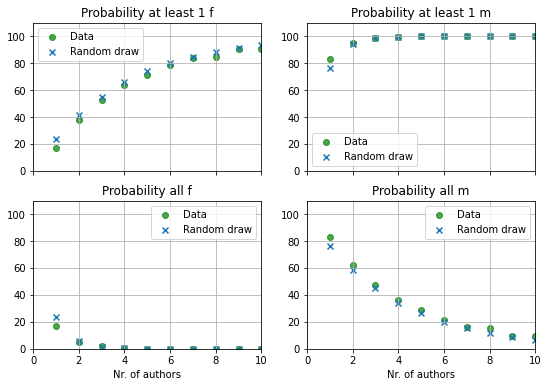

In [12]:
def Prob_author(x,y, kind="female", allkinds="malefemale"):
    sum = 0
    for i,elem in enumerate(x):
        if elem not in allkinds:
            continue
        if elem != kind:
            sum += 1 - float(y[i]) 
        elif elem == kind:
            sum += float(y[i])
    return sum

def count_kind(x, kind="init"):
    sum = 0
    for elem in x:
        if elem == kind:
            sum += 1
    return(sum)
# How many authors in total?
n_authors_all =df.Number_authors.sum()
n_authors_all
# Sum of probability of female / total nr. 
p_female_all = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, kind="female"), axis=1).sum() / n_authors_all

# Sum of probability of male / total nr.
p_male_all = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, kind="male"), axis=1).sum() / n_authors_all

# Sum of init / total nr
p_init_all =  df.apply(lambda x: count_kind(x.all_genders), axis=1).sum() / n_authors_all
# Check it adds to 1
print("All probabilities sum: ", p_female_all + p_male_all + p_init_all)
print("Overall frequency of female authorship: ", 100.*p_female_all)
print("Overall frequency of male authorship: ", 100.*p_male_all)
print("Overall frequency of unidentified names: ", 100. * p_init_all)
print("=" * 100)

# correct for init values
n_init = df.apply(lambda x: count_kind(x.all_genders), axis=1).sum()
# Sum of probability of female / total nr. 
p_female_all = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, kind="female"), axis=1).sum() / (n_authors_all - n_init)

# Sum of probability of male / total nr.
p_male_all = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, kind="male"), axis=1).sum() / (n_authors_all - n_init)
print("All probabilities sum: ", p_female_all + p_male_all)
print("Overall frequency of female authorship after accounting for init: ", 100.*p_female_all)
print("Overall frequency of male authorship after accounting for init: ", 100.*p_male_all)


# so if we go by these rough probabilities then...
print("=" * 100)
print("Probability that a paper with x author(s) has at least 1 female author:")
print("x=1: p=", round(1. - p_male_all, 3), ";   x=2: p=", round(1. - p_male_all ** 2, 3),
      ";   x=3: p=", round(1. - p_male_all ** 3, 3), ";   p=10: p=", round(1. - p_male_all ** 10, 3))
print("=" * 100)
# and the reverse:
print("Probability that a paper with x author(s) has only female authors:")
print("x=1: p=", round(p_female_all, 3), ";   x=2: p=", round(p_female_all ** 2, 3),
      ";   x=3: p=", round(p_female_all ** 3, 3), ";   p=10: p=", round(p_female_all ** 10, 3))
# etc
print("=" * 100)

n_authors = range(1, 21)
p_one_f_given_n = 1. - p_male_all ** n_authors
p_one_m_given_n = 1. - p_female_all ** n_authors

p_all_f_given_n = p_female_all ** n_authors
p_all_m_given_n = p_male_all ** n_authors


# UGLY CODE below. Please fix if you are inspired
n_authors_data = df.Number_authors.unique()
n_authors_data.sort()

p_atleast_f_per_n = []
p_atleast_m_per_n = []
p_all_f_per_n = []
p_all_m_per_n = []
nr_papers_n = []
n_authors_data = n_authors_data[0: 20]
for i in n_authors_data:
    p_atleast_f_per_n.append(100*df[df.Number_authors == i].Prob_atleast_Fauthor.mean())    
    p_atleast_m_per_n.append(100*df[df.Number_authors == i].Prob_atleast_Mauthor.mean())
    p_all_f_per_n.append(100*(1. - df[df.Number_authors == i].Prob_atleast_Mauthor).mean())
    p_all_m_per_n.append(100*(1. - df[df.Number_authors == i].Prob_atleast_Fauthor).mean())
    
    nr_papers_n.append(len(df[df.Number_authors == i])) 
# End ugly crap code
    

plt.figure(figsize=(9, 6))
plt.subplot(221)
plt.scatter(n_authors_data, p_atleast_f_per_n, color="g", alpha=0.7)
plt.scatter(n_authors, 100*p_one_f_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(0., 110)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Probability at least 1 f")
plt.legend(["Data", "Random draw"])


plt.subplot(222)
plt.scatter(n_authors_data, p_atleast_m_per_n, color="g", alpha=0.7)
plt.scatter(n_authors, 100*p_one_m_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(0., 110)
plt.title("Probability at least 1 m")
plt.legend(["Data", "Random draw"])

plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])

plt.subplot(223)
plt.scatter(n_authors_data, p_all_f_per_n, color="g", alpha=0.7)
plt.scatter(n_authors, 100*p_all_f_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(0., 110)

plt.title("Probability all f")
plt.legend(["Data", "Random draw"])

plt.xlabel("Nr. of authors")
plt.subplot(224)
plt.scatter(n_authors_data, p_all_m_per_n, color="g", alpha=0.7)
plt.scatter(n_authors, 100*p_all_m_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(0., 110)
plt.title("Probability all m")
plt.legend(["Data", "Random draw"])
plt.xlabel("Nr. of authors")

plt.savefig("prob_atleast_all.png", dpi=150)
print(nr_papers_n)

Text(0.5, 1.0, 'Bias all m')

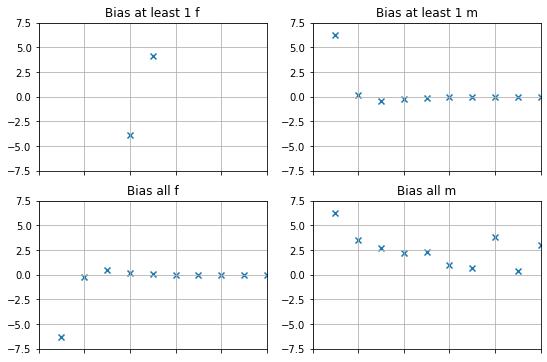

In [37]:
plt.figure(figsize=(9, 6))
plt.subplot(221)
plt.scatter(n_authors_data,  p_atleast_f_per_n - 100*p_one_f_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(-7.5, 7.5)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Bias at least 1 f")


plt.subplot(222)
plt.scatter(n_authors_data, p_atleast_m_per_n - 100*p_one_m_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(-7.5, 7.5)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Bias at least 1 m")


plt.subplot(223)
plt.scatter(n_authors_data,  p_all_f_per_n - 100*p_all_f_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(-7.5, 7.5)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Bias all f")


plt.subplot(224)
plt.scatter(n_authors_data, p_all_m_per_n - 100*p_all_m_given_n, marker="x")
plt.grid()
plt.xlim(0, 10)
plt.ylim(-7.5, 7.5)
plt.xticks([i for i in range(0, 11, 2)], ["" for i in range(0, 11, 2)])
plt.title("Bias all m")

In [27]:
print('Average number of authors for articles', 
      df['Number_authors'].sum()/df.shape[0])

Average number of authors for articles 4.181671748259794


In [33]:
print('Expected probability of having at least one author in an article:', 
      1. - p_male_all ** (df['Number_authors'].sum()/df.shape[0]))
print('Expected probability of having at least one male author in an article:', 
      1. - p_female_all ** (df['Number_authors'].sum()/df.shape[0]))

Expected probability of having at least one author in an article: 0.6732630311211438
Expected probability of having at least one male author in an article: 0.99766834417462


In [34]:
print('Expected probability of having at least one author in an article with 4 authors:', 
      1. - p_male_all ** 4)
print('Expected probability of having at least one male author in an article with 4 authors:', 
      1. - p_female_all ** 4)

Expected probability of having at least one author in an article with 4 authors: 0.6569923407846916
Expected probability of having at least one male author in an article with 4 authors: 0.9969659296558542




##### important: these results may be sensitive to accounting for non-gendered "init" data points in computing the P_atleast.... We should remove them for a cleaner result. I think we could correct for them by enforcing that p_allmale and p_onefemale must sum to one (now not the exact)
- With the number of papers in each category, we may consider everything up to about 10 authors a decent sample size? (for n_authors=10, n_papers = 252)
- men are overrepresented in single-author papers
- gender mixing of authors is not random: the probability of mixed authorships in the data does not reflect a random choice based on overall gender frequencies in the data. The data show more likely all-male and all-female papers compared to random choice by overall frequency. This seems to be particularly the case for all-male author groups. Boys club?
- this may put female authors at disavantage, because their available pool of co-authors is smaller, while men have an increased co-author pool. Female authors may be at disadvantage with regard to forging collaboration


#### We can compute the same quantity per each journal

In [14]:

journals = df['journal'].unique() # a list of unique journal names

df['P_atleast_F_journal'] = df['Prob_atleast_Fauthor'] #initialize the columns
df['P_atleast_M_journal'] = df['Prob_atleast_Mauthor']

for i in journals: #update values for each journal
    cond = df['journal']==i
    print("N = ", len(df[cond].values), " for journal ", i)
    df.loc[cond,'P_atleast_F_journal'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_journal'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]
    

N =  2022  for journal  GRL
N =  1607  for journal  Tectp
N =  1757  for journal  GEOPHYSICS
N =  78  for journal  Science
N =  2024  for journal  BSSA
N =  458  for journal  PEPI
N =  3023  for journal  JGRSolidEarth
N =  1452  for journal  SRL
N =  2541  for journal  GJI
N =  1240  for journal  EPSL
N =  734  for journal  G3
N =  170  for journal  NatureGeoscience
N =  218  for journal  SolidEarth
N =  59  for journal  Nature


##### Make bar plots

(0.0, 1.0)

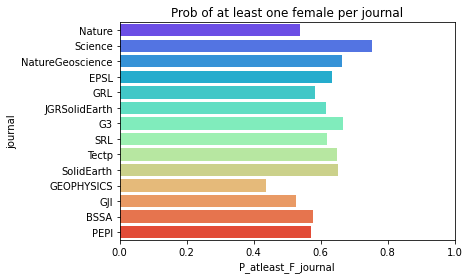

In [15]:
sns.barplot(y="journal", x="P_atleast_F_journal",  data=df, order=dict_IF.keys(), palette='rainbow').set_title('Prob of at least one female per journal')
plt.xlim([0,1])

(0.0, 1.0)

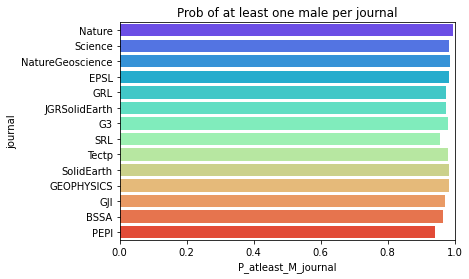

In [16]:
sns.barplot(y="journal", x="P_atleast_M_journal",  data=df, order=dict_IF.keys(), palette='rainbow').set_title('Prob of at least one male per journal')
plt.xlim([0,1])

#### Now we can compare the probability of at least one female author given Nr. of authors for "overall data", "predicted" and "per journal"

['GRL' 'Tectp' 'GEOPHYSICS' 'Science' 'BSSA' 'PEPI' 'JGRSolidEarth' 'SRL'
 'GJI' 'EPSL' 'G3' 'NatureGeoscience' 'SolidEarth' 'Nature']
Papers in bins, BSSA:  [169, 487, 460, 392, 194]
Papers in bins, Science:  [1, 10, 8, 10, 7]
Papers in bins, Nature / Nature Geosc / Science:  [11, 50, 38, 42, 31]
Papers in bins, GJI:  [173, 628, 600, 470, 670]
Papers in bins, JGR:  [134, 598, 601, 568, 360]
Papers in bins, GRL:  [93, 382, 439, 367, 266]
Papers in bins, Geophysics:  [125, 528, 441, 322, 200]
Papers in bins, EPSL:  [44, 211, 199, 205, 192]
Papers in bins, PEPI:  [46, 109, 101, 83, 37]
Papers in bins, G3:  [33, 116, 123, 153, 83]


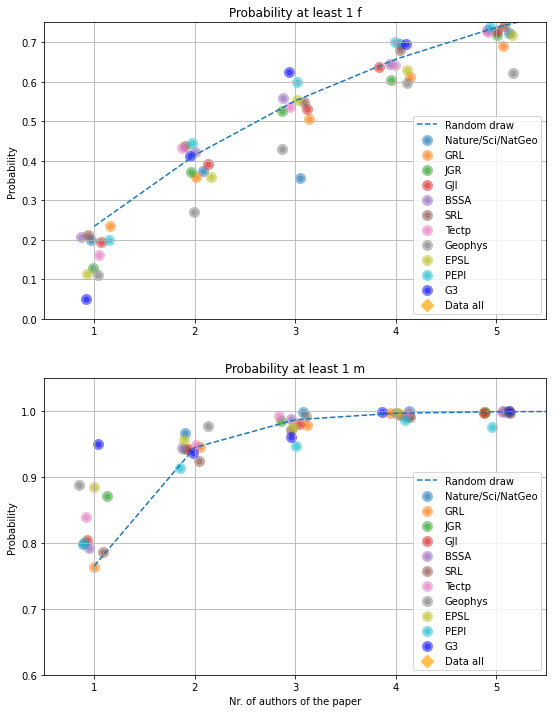

In [17]:
# Another ugly crap code, plz help
p_atleast_f_per_n_natnatgeo = []
p_atleast_m_per_n_natnatgeo = []
nr_papers_n_natnatgeo = []

p_atleast_f_per_n_highIF = []
p_atleast_m_per_n_highIF = []
nr_papers_n_highIF = []

p_atleast_f_per_n_sci = []
nr_papers_n_sci = []

p_atleast_f_per_n_jgr = []
p_atleast_m_per_n_jgr = []
nr_papers_n_jgr = []

p_atleast_f_per_n_gji = []
p_atleast_m_per_n_gji = []
nr_papers_n_gji = []

p_atleast_f_per_n_bssa = []
p_atleast_m_per_n_bssa = []
nr_papers_n_bssa = []

p_atleast_f_per_n_srl = []
p_atleast_m_per_n_srl = []
nr_papers_n_srl = []

p_atleast_f_per_n_gp = []
p_atleast_m_per_n_gp = []
nr_papers_n_gp = []

p_atleast_f_per_n_t = []
p_atleast_m_per_n_t = []
nr_papers_n_t = []

p_atleast_f_per_n_grl = []
p_atleast_m_per_n_grl = []
nr_papers_n_grl = []

p_atleast_f_per_n_pepi = []
p_atleast_m_per_n_pepi = []
nr_papers_n_pepi = []

p_atleast_f_per_n_epsl = []
p_atleast_m_per_n_epsl = []
nr_papers_n_epsl = []

p_atleast_f_per_n_g3 = []
p_atleast_m_per_n_g3 = []
nr_papers_n_g3 = []


for i in range(1, 6):
    
    p_atleast_f_per_n_natnatgeo.append(df[(df.Number_authors == i) & ((df.journal == "Nature") | (df.journal == "NatureGeoscience"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_natnatgeo.append(df[(df.Number_authors == i) & ((df.journal == "Nature") | (df.journal == "NatureGeoscience"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_natnatgeo.append(len(df[(df.Number_authors == i) & ((df.journal == "Nature") | (df.journal == "NatureGeoscience"))]))
    
    p_atleast_f_per_n_highIF.append(df[(df.Number_authors == i) & ((df.journal == "Nature") | (df.journal == "NatureGeoscience") | (df.journal == "Science"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_highIF.append(df[(df.Number_authors == i) & ((df.journal == "Nature") | (df.journal == "NatureGeoscience") | (df.journal == "Science"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_highIF.append(len(df[(df.Number_authors == i) & ((df.journal == "Nature") | (df.journal == "NatureGeoscience") | (df.journal == "Science"))]))
    
    p_atleast_f_per_n_sci.append(df[(df.Number_authors == i) & (df.journal == "Science")].Prob_atleast_Fauthor.mean())  
    nr_papers_n_sci.append(len(df[(df.Number_authors == i) & ((df.journal == "Science"))]))
    
    p_atleast_f_per_n_jgr.append(df[(df.Number_authors == i) & ((df.journal == "JGRSolidEarth"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_jgr.append(df[(df.Number_authors == i) & ((df.journal == "JGRSolidEarth"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_jgr.append(len(df[(df.Number_authors == i) & ((df.journal == "JGRSolidEarth"))]))
    
    p_atleast_f_per_n_gji.append(df[(df.Number_authors == i) & ((df.journal == "GJI"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_gji.append(df[(df.Number_authors == i) & ((df.journal == "GJI"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_gji.append(len(df[(df.Number_authors == i) & ((df.journal == "GJI"))]))
    
    p_atleast_f_per_n_bssa.append(df[(df.Number_authors == i) & ((df.journal == "BSSA"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_bssa.append(df[(df.Number_authors == i) & ((df.journal == "BSSA"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_bssa.append(len(df[(df.Number_authors == i) & ((df.journal == "BSSA"))]))
    
    p_atleast_f_per_n_t.append(df[(df.Number_authors == i) & ((df.journal == "Tectp"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_t.append(df[(df.Number_authors == i) & ((df.journal == "Tectp"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_t.append(len(df[(df.Number_authors == i) & ((df.journal == "Tectp"))]))
    
    p_atleast_f_per_n_srl.append(df[(df.Number_authors == i) & ((df.journal == "SRL"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_srl.append(df[(df.Number_authors == i) & ((df.journal == "SRL"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_srl.append(len(df[(df.Number_authors == i) & ((df.journal == "SRL"))]))
    
    p_atleast_f_per_n_gp.append(df[(df.Number_authors == i) & ((df.journal == "GEOPHYSICS"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_gp.append(df[(df.Number_authors == i) & ((df.journal == "GEOPHYSICS"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_gp.append(len(df[(df.Number_authors == i) & ((df.journal == "GEOPHYSICS"))]))
    
    p_atleast_f_per_n_grl.append(df[(df.Number_authors == i) & ((df.journal == "GRL"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_grl.append(df[(df.Number_authors == i) & ((df.journal == "GRL"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_grl.append(len(df[(df.Number_authors == i) & ((df.journal == "GRL"))]))
    
    p_atleast_f_per_n_pepi.append(df[(df.Number_authors == i) & ((df.journal == "PEPI"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_pepi.append(df[(df.Number_authors == i) & ((df.journal == "PEPI"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_pepi.append(len(df[(df.Number_authors == i) & ((df.journal == "PEPI"))]))
    
    p_atleast_f_per_n_epsl.append(df[(df.Number_authors == i) & ((df.journal == "EPSL"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_epsl.append(df[(df.Number_authors == i) & ((df.journal == "EPSL"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_epsl.append(len(df[(df.Number_authors == i) & ((df.journal == "EPSL"))]))
    
    p_atleast_f_per_n_g3.append(df[(df.Number_authors == i) & ((df.journal == "G3"))].Prob_atleast_Fauthor.mean())  
    p_atleast_m_per_n_g3.append(df[(df.Number_authors == i) & ((df.journal == "G3"))].Prob_atleast_Mauthor.mean())  
    nr_papers_n_g3.append(len(df[(df.Number_authors == i) & ((df.journal == "G3"))]))

# End ugly crap code

print(df.journal.unique())
plt.figure(figsize=(9, 12))
plt.subplot(211)

h0, = plt.plot(n_authors, p_one_f_given_n, "--")
h1 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_highIF, linewidth=5, alpha=0.5)
h3 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_grl, linewidth=5, alpha=0.5)
h4 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_gji, linewidth=5, alpha=0.5)
h5 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_jgr,linewidth=5, alpha=0.5)
h6 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_bssa, linewidth=5, alpha=0.5)
h7 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_srl, linewidth=5, alpha=0.5)
h8 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_t,  linewidth=5, alpha=0.5)
h9 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_gp,linewidth=5, alpha=0.5)
h10 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_epsl, linewidth=5, alpha=0.5)
h11 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_pepi, linewidth=5, alpha=0.5)
h12 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_f_per_n_g3, color="b", linewidth=5, alpha=0.5)
h13 = plt.scatter(n_authors_data, p_atleast_f_per_n, color="orange", marker="x", linewidth=10, alpha=0.7)
plt.grid()
plt.ylabel("Probability")

plt.ylim(0.0, 0.75)
plt.title("Probability at least 1 f")
plt.legend([h0, h1, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13],
    ["Random draw", "Nature/Sci/NatGeo", "GRL", "JGR", "GJI", "BSSA", "SRL", "Tectp", "Geophys","EPSL", "PEPI", "G3", "Data all",])
plt.xlim(0.5, 5.5)
print("Papers in bins, BSSA: ", nr_papers_n_bssa)
print("Papers in bins, Science: ", nr_papers_n_sci)
print("Papers in bins, Nature / Nature Geosc / Science: ", nr_papers_n_highIF)
print("Papers in bins, GJI: ", nr_papers_n_gji)
print("Papers in bins, JGR: ", nr_papers_n_jgr)
print("Papers in bins, GRL: ", nr_papers_n_grl)
print("Papers in bins, Geophysics: ", nr_papers_n_gp)
print("Papers in bins, EPSL: ", nr_papers_n_epsl)
print("Papers in bins, PEPI: ", nr_papers_n_pepi)
print("Papers in bins, G3: ", nr_papers_n_g3)

plt.subplot(212)
h0, = plt.plot(n_authors, p_one_m_given_n, "--")
h1 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_highIF, linewidth=5, alpha=0.5)
h3 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_grl,  linewidth=5, alpha=0.5)
h4 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_gji, linewidth=5, alpha=0.5)
h5 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_jgr,  linewidth=5, alpha=0.5)
h6 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_bssa, linewidth=5, alpha=0.5)
h7 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_srl, linewidth=5, alpha=0.5)
h8 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_t, linewidth=5, alpha=0.5)
h9 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_gp, linewidth=5, alpha=0.5)
h10 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_epsl, linewidth=5, alpha=0.5)
h11 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_pepi, linewidth=5, alpha=0.5)
h12 = plt.scatter(np.arange(1, 6) + (np.random.random(5) - 0.5) / 3.0, p_atleast_m_per_n_g3, color="b", linewidth=5, alpha=0.5)
h13 = plt.scatter(n_authors_data, p_atleast_m_per_n, color="orange", marker="x", linewidth=10, alpha=0.7)

plt.grid()
plt.ylim(0.6, 1.05)
plt.title("Probability at least 1 m")
plt.legend([h0, h1, h3, h4, h5, h6, h7, h8, h9, h10, h11, h12, h13],
    ["Random draw", "Nature/Sci/NatGeo", "GRL", "JGR", "GJI", "BSSA", "SRL", "Tectp", "Geophys","EPSL", "PEPI", "G3", "Data all",])
plt.xlim(0.5, 5.5)
plt.xlabel("Nr. of authors of the paper")
plt.ylabel("Probability")
plt.savefig("p_atleast_per_n_per_journal.png", dpi=150)

#### I don't think there is a particularly strong effect of impact factor? It is hard to tell because n is small for Nature etc... overall we just see that female authors have more difficulty to be in predominantly male papers, than male authors to be in predominantly female papers, and that there seems to be a homophily effect jejejeje
##### Please help me double check if the argumentation makes sense
##### I added random x-offsets to the plotted values for better visibility

#### See the temporal trend of having at least one F or one M in a publication for all journals per year


In [18]:
years = df['year'].unique() # a list of unique journal names
years.sort()
print(years)

for i in years: #update values for each journal
    cond = df['year']==i
    print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_atleast_F_year'] = df.loc[cond,'Prob_atleast_Fauthor'].sum()/df[cond].shape[0]
    df.loc[cond,'P_atleast_M_year'] = df.loc[cond,'Prob_atleast_Mauthor'].sum()/df[cond].shape[0]



['2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020']
Number of articles =  1253  for year  2010
Number of articles =  1197  for year  2011
Number of articles =  1252  for year  2012
Number of articles =  1562  for year  2013
Number of articles =  1512  for year  2014
Number of articles =  1553  for year  2015
Number of articles =  1711  for year  2016
Number of articles =  1646  for year  2017
Number of articles =  1850  for year  2018
Number of articles =  1753  for year  2019
Number of articles =  2094  for year  2020


(0.0, 1.0)

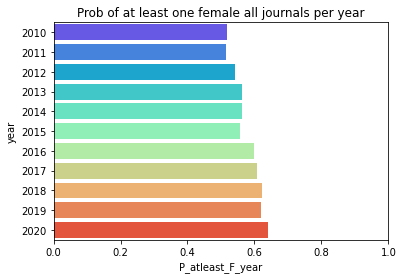

In [19]:
sns.barplot(y="year", x="P_atleast_F_year",  data=df, order=years, palette='rainbow').set_title('Prob of at least one female all journals per year')
plt.xlim([0,1])

(0.0, 1.0)

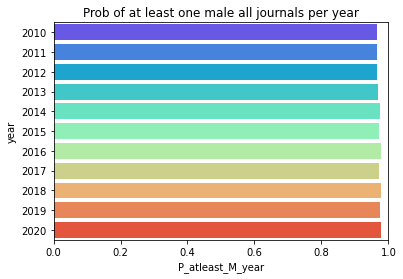

In [20]:
sns.barplot(y="year", x="P_atleast_M_year",  data=df, order=years, palette='rainbow').set_title('Prob of at least one male all journals per year')
plt.xlim([0,1])

#### Female & male percentages per year 

In [21]:
# To discuss: Here we should make sure that "male" only counts "male"
# last_auth_F_year = df.groupby(['year'])['Last_Author_gend'].apply(lambda x: x[x.str.contains('female')].count())
# print(last_auth_F_year)

# last_auth_M_year = df.groupby(['year'])['Last_Author_gend'].apply(lambda x: x[x.str.contains('male')].count())
# print(last_auth_M_year)

# first_auth_F_year = df.groupby(['year'])['First_Author_gend'].apply(lambda x: x[x.str.contains('female')].count())
# print(first_auth_F_year)

# first_auth_M_year = df.groupby(['year'])['First_Author_gend'].apply(lambda x: x[x.str.contains('male')].count())
# print(first_auth_M_year)

# first author> someone needs to double check this! 
for i in years: #update values for each journal
    cond = (df['year']==i) & (df["First_Author_gend"] != "init")  
    # alternatively: Do not remove Init and then probabilities do not sum to 1.
    # cond = df['year']==i
    
    print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_first_F_year'] = df.loc[cond,'First_Author_probF'].sum() / len(df.loc[cond])
    df.loc[cond,'P_first_M_year'] = (1. - df.loc[cond,'First_Author_probF']).sum() / len(df.loc[cond])
    
    # uncomment the following line to check if sums up to 1
    # print(df.loc[cond, "P_first_F_year"].iloc[0:5] + df.loc[cond, "P_first_M_year"].iloc[0:5])
    print("Probability that first author is female: ", df.loc[cond, "P_first_F_year"].iloc[0])
    print("Probability that first author is male: ", df.loc[cond, "P_first_M_year"].iloc[0])

    
    # last author
    cond = (df['year']==i) & (df["Last_Author_gend"] != "init")  
    # alternatively: Do not remove Init and then probabilities do not sum to 1.
    # cond = df['year']==i
    
    #print("Number of articles = ", len(df[cond].values), " for year ", i)
    df.loc[cond,'P_last_F_year'] = df.loc[cond,'Last_Author_probF'].sum() / len(df.loc[cond])
    df.loc[cond,'P_last_M_year'] = (1. - df.loc[cond,'Last_Author_probF']).sum() / len(df.loc[cond])
    
    # uncomment the following line to check if sums up to 1
    # print(df.loc[cond, "P_last_F_year"].iloc[0:5] + df.loc[cond, "P_last_M_year"].iloc[0:5])
    print("Probability that last author is female: ", df.loc[cond, "P_last_F_year"].iloc[0])
    print("Probability that last author is male: ", df.loc[cond, "P_last_M_year"].iloc[0])

df.to_csv("analysis_output_" + time.strftime("%Y-%m-%d.csv"))

Number of articles =  1253  for year  2010
Probability that first author is female:  0.2550608965522664
Probability that first author is male:  0.7449391034477337
Probability that last author is female:  0.18061824783448713
Probability that last author is male:  0.8193817521655129
Number of articles =  1197  for year  2011
Probability that first author is female:  0.25515735880568013
Probability that first author is male:  0.7448426411943199
Probability that last author is female:  0.1813623998004091
Probability that last author is male:  0.8186376001995909
Number of articles =  1252  for year  2012
Probability that first author is female:  0.265585673320223
Probability that first author is male:  0.734414326679777
Probability that last author is female:  0.18254779503591648
Probability that last author is male:  0.8174522049640836
Number of articles =  1562  for year  2013
Probability that first author is female:  0.2742907608695704
Probability that first author is male:  0.7257092391

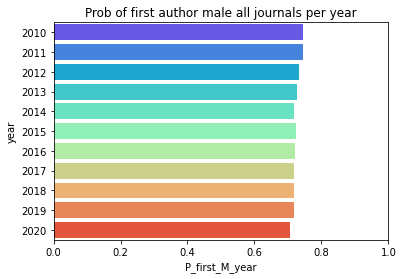

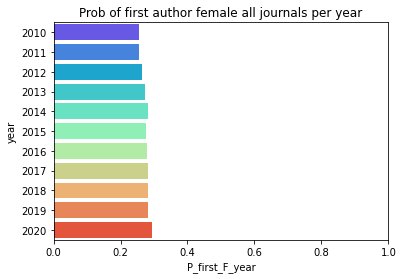

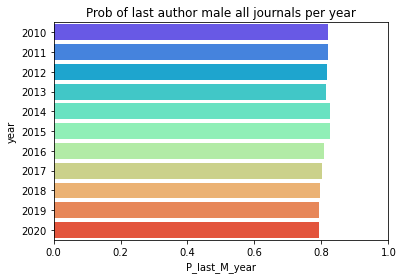

(0.0, 1.0)

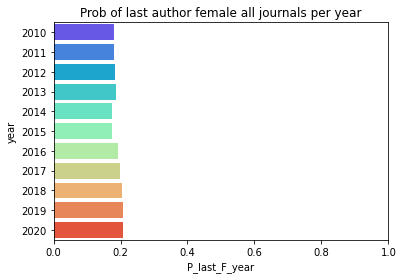

In [22]:
sns.barplot(y="year", x="P_first_M_year",  data=df, order=years, palette='rainbow').set_title('Prob of first author male all journals per year')
plt.xlim([0,1])
plt.show()

sns.barplot(y="year", x="P_first_F_year",  data=df, order=years, palette='rainbow').set_title('Prob of first author female all journals per year')
plt.xlim([0,1])
plt.show()


sns.barplot(y="year", x="P_last_M_year",  data=df, order=years, palette='rainbow').set_title('Prob of last author male all journals per year')
plt.xlim([0,1])
plt.show()

sns.barplot(y="year", x="P_last_F_year",  data=df, order=years, palette='rainbow').set_title('Prob of last author female all journals per year')
plt.xlim([0,1])

#### We should check if the numbers above are biased or are a consequence of female/male author distribution.

We can generate synthetic data using the distribution of female/male authors.

--> The synthetics have moved to analysis-Synthetics notebook, remain below for not accidentally deleting something useful

In [23]:
def Prob_author(x,y, kind="female", allkinds="malefemale"):
    sum = 0
    for i, elem in enumerate(x):
        if elem not in allkinds:
            continue
        if elem != kind:
            sum += 1 - float(y[i]) 
        elif elem == kind:
            sum += float(y[i])
    return sum


df['Prob_Fauthor'] = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, "female"), axis=1)
df['Prob_Mauthor'] = df.apply(lambda x: Prob_author(x.all_genders, x.all_percent, "male"), axis=1)

df

,year,journal,all_genders,all_percent,IF,Number_authors,Number_init,First_Author_gend,First_Author_perc,Last_Author_gend,...,P_atleast_F_journal,P_atleast_M_journal,P_atleast_F_year,P_atleast_M_year,P_first_F_year,P_first_M_year,P_last_F_year,P_last_M_year,Prob_Fauthor,Prob_Mauthor
0,2010,GRL,"[male, male]","[0.99, 0.99]",4.952,2,0,male,0.99,male,...,0.583452,0.973757,0.518233,0.966080,0.255061,0.744939,0.180618,0.819382,0.020000,1.980000
1,2017,Tectp,"[male, male, male, female, male, male]","[0.99, 1.0, 1.0, 0.5, 0.98, 0.9]",3.048,6,0,male,0.99,male,...,0.650497,0.981794,0.606577,0.972805,0.281817,0.718183,0.198139,0.801861,0.630000,5.370000
2,2019,GEOPHYSICS,[male],[0.98],3.093,1,0,male,0.98,male,...,0.437551,0.982960,0.620168,0.976257,0.281485,0.718515,0.205885,0.794115,0.020000,0.980000
3,2016,Science,"[male, female, male, male, male, male, male, f...","[0.99, 0.93, 0.99, 0.99, 1.0, 1.0, 0.75, 0.93,...",41.845,48,0,male,0.99,male,...,0.754775,0.983965,0.597316,0.978669,0.279786,0.720214,0.192132,0.807868,14.802914,33.197086
5,2019,Tectp,"[male, male, male, male, male, male, male, fem...","[0.57, 0.74, 1.0, 1.0, 0.63, 0.93, 0.690361645...",3.048,8,0,male,0.57,female,...,0.650497,0.981794,0.620168,0.976257,0.281485,0.718515,0.205885,0.794115,2.439638,5.560362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19355,2012,EPSL,"[male, male]","[0.97, 0.99]",4.823,2,0,male,0.97,male,...,0.634609,0.983941,0.541955,0.966165,0.265586,0.734414,0.182548,0.817452,0.040000,1.960000
19356,2020,GRL,"[male, male]","[0.88, 0.99]",4.952,2,0,male,0.88,male,...,0.583452,0.973757,0.640497,0.978662,0.293385,0.706615,0.206187,0.793813,0.130000,1.870000
19357,2015,NatureGeoscience,"[female, male, male, male]","[0.98, 0.98, 1.0, 0.98]",16.103,4,0,female,0.98,male,...,0.663366,0.986145,0.557641,0.971262,0.274680,0.725320,0.173168,0.826832,1.020000,2.980000
19358,2017,JGRSolidEarth,"[female, male]","[0.5, 0.99]",4.191,2,0,female,0.50,male,...,0.615495,0.974775,0.606577,0.972805,0.281817,0.718183,0.198139,0.801861,0.510000,1.490000


In [24]:
### Define a random sampler from the distribution of female/male authors:

elements = ['female', 'male', 'init']
p1 = df['Prob_Fauthor'].sum()/df['Number_authors'].sum() #prob of an author being female
p2 = df['Prob_Mauthor'].sum()/df['Number_authors'].sum() #prob of an author being male
p3 = 1 - p1 - p2 #prob of an author being init

probabilities = [p1, p2 , p3]
np.random.choice(elements, 10, p=probabilities) # example: take 10 random samples



array(['male', 'male', 'female', 'male', 'male', 'male', 'male', 'male',
       'male', 'male'], dtype='<U6')

In [25]:
# Generate synthetic genders per each article maintaining the number of authors:

dfn = pd.DataFrame()

dfn['Synth_genders'] = df['Number_authors'].apply(lambda x: np.random.choice(elements, x, p=probabilities))
dfn

,Synth_genders
0,"[female, male]"
1,"[male, male, female, male, male, female]"
2,[female]
3,"[male, female, male, male, male, female, male,..."
5,"[male, male, male, male, male, female, female,..."
...,...
19355,"[male, male]"
19356,"[male, male]"
19357,"[female, male, female, male]"
19358,"[female, male]"


In [26]:
### Now check for these synthetics the probabilities:

# prob having at least one female author

def Prob_atleast_Fauthor_synth(x):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 1 
        elif elem == 'female':
            prod *= 0
    return 1 - prod

dfn['Prob_atleast_Fauthor_synth'] = dfn.apply(lambda x: Prob_atleast_Fauthor_synth(x.Synth_genders), axis=1)

print('Probability of having at least one female author in an article', 
      dfn['Prob_atleast_Fauthor_synth'].sum()/dfn.shape[0])

# prob having at least one male author

def Prob_atleast_Mauthor_synth(x):
    prod = 1
    for i,elem in enumerate(x):
        if elem == 'male':
            prod *= 0
        elif elem == 'female':
            prod *= 1
    return 1 - prod

dfn['Prob_atleast_Mauthor_synth'] = dfn.apply(lambda x: Prob_atleast_Mauthor_synth(x.Synth_genders), axis=1)

print('Probability of having at least one male author in an article',
      dfn['Prob_atleast_Mauthor_synth'].sum()/dfn.shape[0])


### What is the prob of first and last authorships?


dfn['First_Author_Fperc_synth'] = dfn['Synth_genders'].apply(lambda x: 1 if x[0]=='female' else 0)
dfn['First_Author_Mperc_synth'] = dfn['Synth_genders'].apply(lambda x: 1 if x[0]=='male' else 0)

dfn['Last_Author_Fperc_synth'] = dfn['Synth_genders'].apply(lambda x: 1 if x[-1]=='female' else 0)
dfn['Last_Author_Mperc_synth'] = dfn['Synth_genders'].apply(lambda x: 1 if x[-1]=='male' else 0)

print('First author female:', dfn['First_Author_Fperc_synth'].sum()/dfn.shape[0])
print('First author male:', dfn['First_Author_Mperc_synth'].sum()/dfn.shape[0])
print('Last author female:', dfn['Last_Author_Fperc_synth'].sum()/dfn.shape[0])
print('Last author male:', dfn['Last_Author_Mperc_synth'].sum()/dfn.shape[0])

Probability of having at least one female author in an article 0.6081228786745672
Probability of having at least one male author in an article 0.9696830236437899
First author female: 0.23269861358798827
First author male: 0.7671863314732785
Last author female: 0.2305125697520566
Last author male: 0.7694299027785768
